# Analysis of Anger in Posts

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
from itertools import combinations
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

Load data and specify dependent and independent variables

In [30]:
pd.set_option('display.float_format', '{:.8f}'.format)

sentiments = pd.read_csv(
    "combined_sentiments.csv", 
    keep_default_na=False,  # Prevents default strings (like 'None', 'NA') from becoming NaN
    na_values=['']          # Optional: Specify that only empty strings should be NaN
)

dv = "anger_p"
iv1 = "dominant_emotion_a"
iv2 = "NewsroomTopic"

Choose if you want to do a logit transformation

In [4]:
logit_transformation = False

if logit_transformation:
    sentiments['anger_p_logit'] = np.log((sentiments[dv]) / (1 - sentiments[dv]))
    dv_use = 'anger_p_logit'
    
    compare_logit = sentiments[['anger_p', 'anger_p_logit']]

    print(f'max: {max(compare_logit['anger_p'])}')
    print(f'min: {min(compare_logit['anger_p'])}')
    print(f'max logit: {max(compare_logit['anger_p_logit'])}')
    print(f'min logit: {min(compare_logit['anger_p_logit'])}')
    
    compare_logit.head()
else:
    dv_use = dv
    print(f'max: {max(sentiments['anger_p'])}')
    print(f'min: {min(sentiments['anger_p'])}')


max: 0.9972729086875916
min: 2.2472344426205385e-05


Check distributions of anger in posts across dominant emotions of articles

dominant_emotion_a=Fear: W=0.9338, p=0.0000


c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 98783.
  res = hypotest_fun_out(*samples, **kwds)


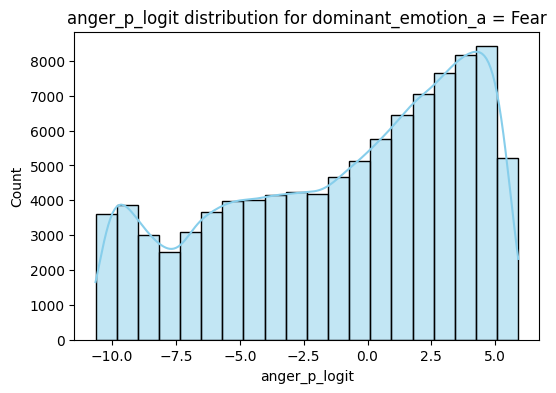

dominant_emotion_a=Anger: W=0.9293, p=0.0000


c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9973.
  res = hypotest_fun_out(*samples, **kwds)


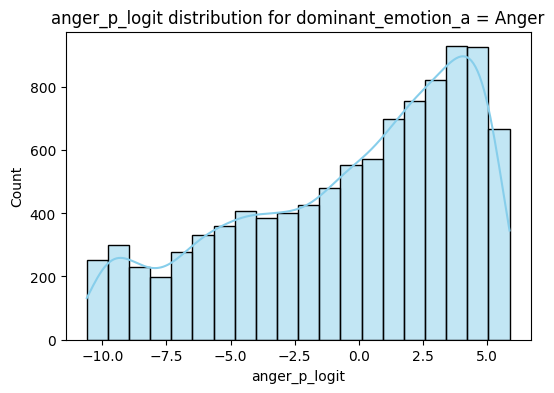

dominant_emotion_a=Sadness: W=0.9446, p=0.0000


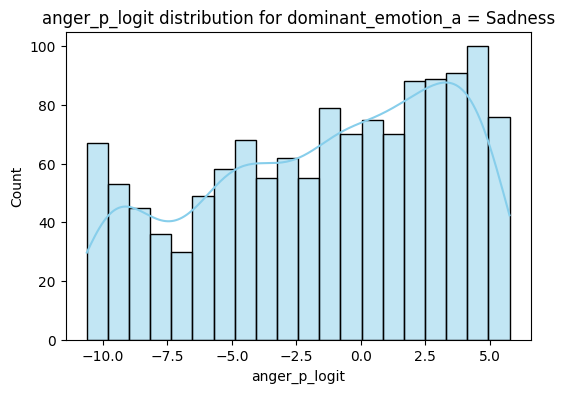

dominant_emotion_a=Joy: W=0.9670, p=0.0000


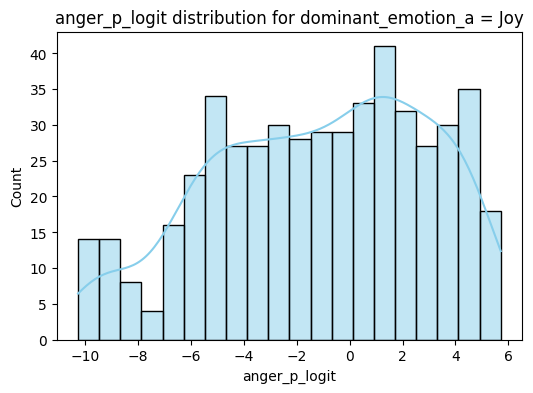

dominant_emotion_a=Disgust: W=0.9205, p=0.0000


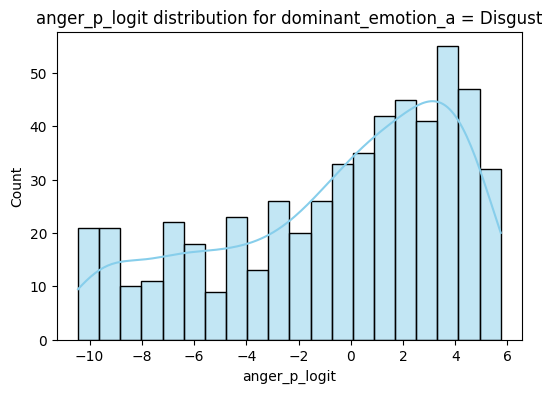

In [32]:
for level in sentiments[iv1].unique():
    group_data = sentiments.loc[sentiments[iv1] == level, dv_use]
    if len(group_data) >= 3:
        stat, p = shapiro(group_data)
        print(f"{iv1}={level}: W={stat:.4f}, p={p:.4f}")
        
        plt.figure(figsize=(6,4))
        sns.histplot(group_data, bins=20, kde=True, color='skyblue')
        plt.title(f"{dv_use} distribution for {iv1} = {level}")
        plt.xlabel(dv_use)
        plt.ylabel("Count")
        plt.show()

Check distributions of anger in posts across topics of articles

NewsroomTopic=User: W=0.9406, p=0.0000


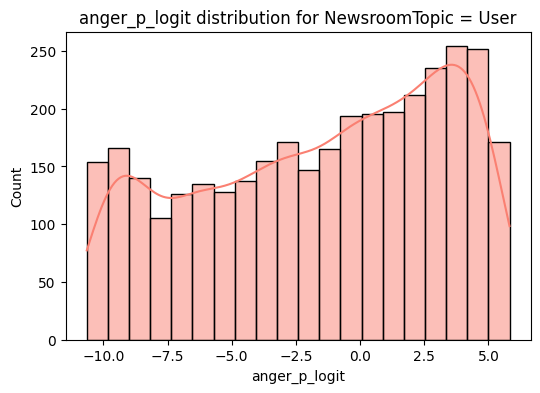

NewsroomTopic=Wissenschaft: W=0.9518, p=0.0000


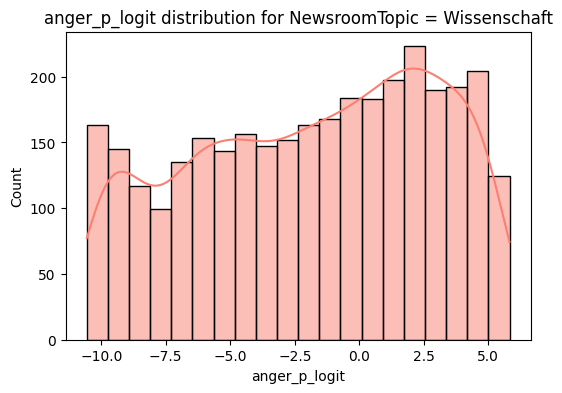

NewsroomTopic=Web: W=0.9482, p=0.0000


c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12998.
  res = hypotest_fun_out(*samples, **kwds)


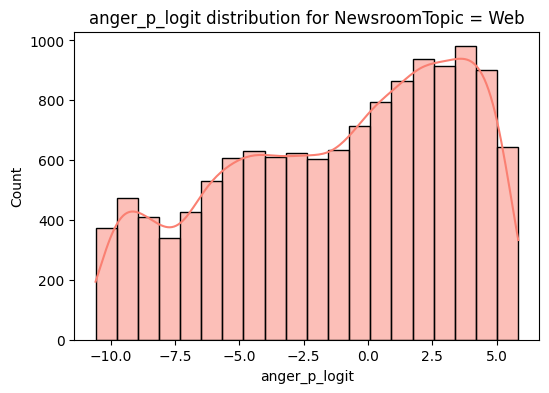

c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21186.
  res = hypotest_fun_out(*samples, **kwds)


NewsroomTopic=International: W=0.9324, p=0.0000


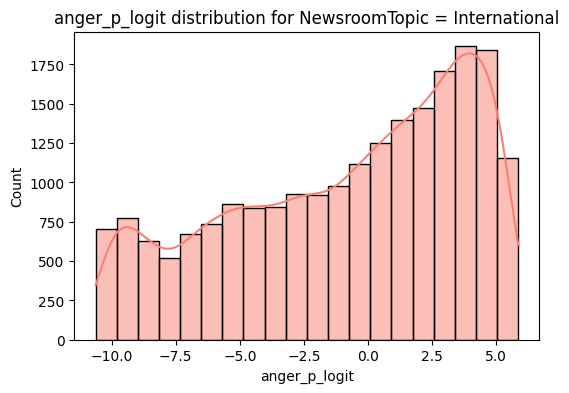

c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 29663.
  res = hypotest_fun_out(*samples, **kwds)


NewsroomTopic=Panorama: W=0.9337, p=0.0000


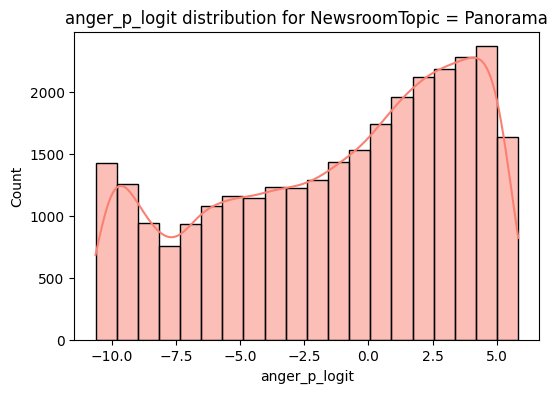

c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26557.
  res = hypotest_fun_out(*samples, **kwds)


NewsroomTopic=Inland: W=0.9269, p=0.0000


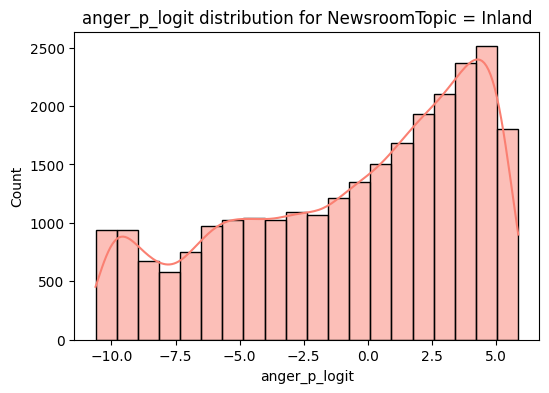

NewsroomTopic=Sport: W=0.9553, p=0.0000


c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9186.
  res = hypotest_fun_out(*samples, **kwds)


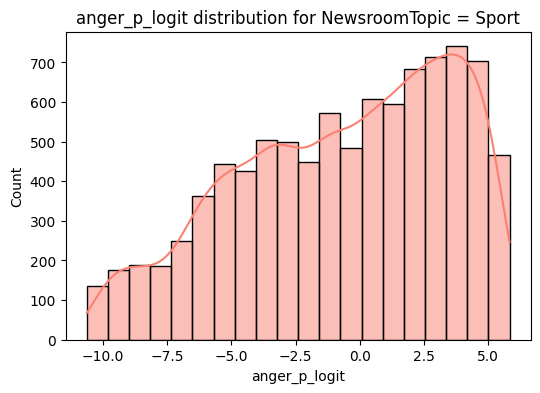

c:\Users\morit\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 21158.
  res = hypotest_fun_out(*samples, **kwds)


NewsroomTopic=Wirtschaft: W=0.9299, p=0.0000


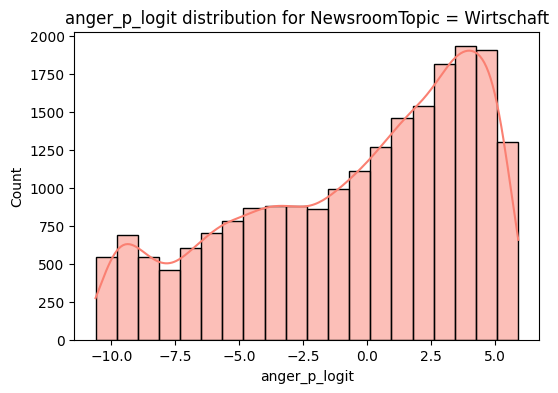

NewsroomTopic=Etat: W=0.9336, p=0.0000


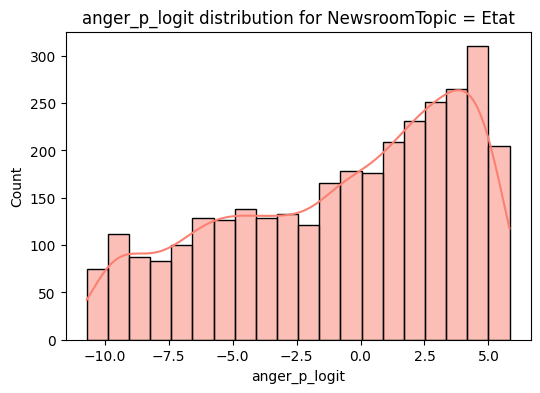

NewsroomTopic=Kultur: W=0.9467, p=0.0000


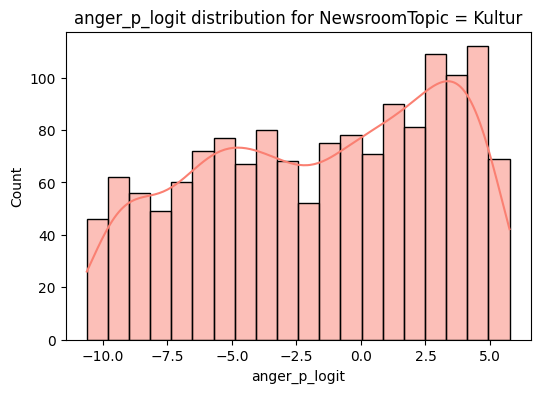

In [33]:
for level in sentiments[iv2].unique():
    group_data = sentiments.loc[sentiments[iv2] == level, dv_use]
    if len(group_data) >= 3:
        stat, p = shapiro(group_data)
        print(f"{iv2}={level}: W={stat:.4f}, p={p:.4f}")
        
        # Plot distribution
        plt.figure(figsize=(6,4))
        sns.histplot(group_data, bins=20, kde=True, color='salmon')
        plt.title(f"{dv_use} distribution for {iv2} = {level}")
        plt.xlabel(dv_use)
        plt.ylabel("Count")
        plt.show()

Choose if you want to remove statistical outliers and a threshold for extreme residuals and a minimal group size

In [ ]:
remove_extremes = True
threshold = 0.025
min_group_size = 20

In [ ]:
def prepare_test_data():

    print(f"Initial observations: {len(sentiments)}")

    counts_before = sentiments.groupby([iv2, iv1]).size().unstack(fill_value=0)
    counts_before['Total'] = counts_before.sum(axis=1)
    counts_before.loc['Total'] = counts_before.sum(axis=0)
    print("\nCounts of each NewsroomTopic x dominant_emotion_a BEFORE filtering:")
    print(counts_before)

    test_data = sentiments.copy()

    if remove_extremes:
        formula_init = f"{dv_use} ~ C({iv1}) + C({iv2})"
        model_init = smf.ols(formula_init, data=test_data).fit()
        residuals_init = model_init.resid.reindex(test_data.index)

        lower = residuals_init.quantile(threshold)
        upper = residuals_init.quantile(1 - threshold)

        mask = residuals_init.between(lower, upper)
        test_data = test_data.loc[mask].copy()

        print(f"\nRemoved top and bottom {threshold} of extreme residuals: kept {len(test_data)} observations")

    test_data = test_data.groupby([iv2, iv1]).filter(lambda x: len(x) >= min_group_size)
    if min_group_size > 1:
        print(f"\nRemoved groups with fewer than {min_group_size} observations: kept {len(test_data)} observations")

    counts_after = test_data.groupby([iv2, iv1]).size().unstack(fill_value=0)
    counts_after['Total'] = counts_after.sum(axis=1)
    counts_after.loc['Total'] = counts_after.sum(axis=0)
    print("\nCounts of each NewsroomTopic x dominant_emotion_a AFTER filtering:")
    print(counts_after)

    return test_data

test_data = prepare_test_data()

Initial observations: 132121

Counts of each NewsroomTopic x dominant_emotion_a BEFORE filtering:
dominant_emotion_a  Anger  Disgust   Fear  Joy  Sadness   Total
NewsroomTopic                                                  
Etat                  988        7   1634   27        7    2663
Inland               2958        0  18998   63        0   22019
International         739      117  17466    1      135   18458
Kultur                 60        0   1190   27       72    1349
Panorama             1532      425  23099   52      790   25898
Sport                 414        1   3845  225      266    4751
User                   39        0   3355   19       14    3427
Web                  1452        0   9394   16       12   10874
Wirtschaft           1776        0  16987    0       15   18778
Wissenschaft           15        0   2815   69        5    2904
Total                9973      550  98783  499     1316  111121

Removed top and bottom 0.001 of extreme residuals: kept 110897 observ

Check for homoskedacity of variances whitin main factors

In [36]:
def levene_test(iv):

    groups = [test_data.loc[test_data[iv] == lvl, dv_use] for lvl in test_data[iv].unique()]

    stat, p = levene(*groups, center='median')
    print(f"Levene test for equal variances across {iv}:")

    if p < 0.05:
        print(f"  → ANOVA assumption of homoscedasticity is VIOLATED for {iv}.")
    else:
        print(f"  → ANOVA assumption of homoscedasticity is OK for {iv}.")

levene_test(iv1)
levene_test(iv2)

Levene test for equal variances across dominant_emotion_a:
  → ANOVA assumption of homoscedasticity is VIOLATED for dominant_emotion_a.
Levene test for equal variances across NewsroomTopic:
  → ANOVA assumption of homoscedasticity is VIOLATED for NewsroomTopic.


Perform bootstrapped testings to correct for violations of assumptions

In [37]:
random_state = 12
alpha = 0.001
n_boot = 1000

1. ANOVA with bootstrapped eta_p2

Significane Labels are retrieved from confidence intervals of eta_p2 that exclude 0

In [ ]:
def bootstrap_anova():

    np.random.seed(random_state)

    formula = f"{dv_use} ~ C({iv1}) + C({iv2})"
    model = smf.ols(formula, data=test_data).fit()

    anova_df = anova_lm(model, typ=2).reset_index()
    ss_error = anova_df.loc[anova_df['index'] == 'Residual', 'sum_sq'].values[0]
    df_error = int(model.df_resid)

    results_list = []

    for _, row in anova_df.iterrows():
        effect = row['index']
        if effect == 'Residual':
            continue

        df_effect = int(row['df'])
        F_orig = row['F']
        eta_p2_orig = row['sum_sq'] / (row['sum_sq'] + ss_error)

        boot_eta = []
        for _ in range(n_boot):
            df_boot = test_data.sample(n=len(test_data), replace=True)
            model_boot = smf.ols(formula, data=df_boot).fit()
            anova_boot = anova_lm(model_boot, typ=2)
            ss_error_boot = anova_boot.loc['Residual', 'sum_sq']
            ss_effect_boot = anova_boot.loc[effect, 'sum_sq']
            eta_p2_boot = ss_effect_boot / (ss_effect_boot + ss_error_boot)
            boot_eta.append(eta_p2_boot)

        ci_lower = np.percentile(boot_eta, 100 * (alpha / 2))
        ci_upper = np.percentile(boot_eta, 100 * (1 - alpha / 2))

        significant = (ci_lower > 0) or (ci_upper < 0)

        results_list.append({
            "effect": effect,
            "F": F_orig,
            "eta_p2": eta_p2_orig,
            "eta_p2_ci_lower": ci_lower,
            "eta_p2_ci_upper": ci_upper,
            "df_effect": df_effect,
            "df_error": df_error,
            "significant": significant
        })

    return pd.DataFrame(results_list)

In [39]:
anova_results = bootstrap_anova()
anova_results

,effect,F,eta_p2,eta_p2_ci_lower,eta_p2_ci_upper,df_effect,df_error,significant
0,C(dominant_emotion_a),39.63583270,0.00142778,0.00082393,0.00221265,4,110883,True
1,C(NewsroomTopic),61.11176546,0.00493575,0.00383009,0.00623497,9,110883,True


2. Post Hoc tests

Significane Labels are retrieved from confidence intervals of mean differences that exclude 0

In [ ]:
def bootstrap_pairwise(iv):

    np.random.seed(random_state)

    levels = test_data[iv].unique()
    combs = list(combinations(levels, 2))
    results = []

    for a, b in combs:
        data_a = test_data[test_data[iv] == a][dv_use].values
        data_b = test_data[test_data[iv] == b][dv_use].values

        mean_a = data_a.mean()
        mean_b = data_b.mean()
        mean_diff = mean_a - mean_b

        diff_boot = []
        for _ in range(n_boot):
            sample_a = np.random.choice(data_a, size=len(data_a), replace=True)
            sample_b = np.random.choice(data_b, size=len(data_b), replace=True)
            diff_boot.append(sample_a.mean() - sample_b.mean())

        ci_lower = np.percentile(diff_boot, 100 * (alpha / 2))
        ci_upper = np.percentile(diff_boot, 100 * (1 - alpha / 2))

        significant = (ci_lower > 0) or (ci_upper < 0)

        results.append({
            "group_a": a,
            "group_b": b,
            "mean_a": mean_a,
            "mean_b": mean_b,
            "mean_diff": mean_diff,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper,
            "significant": significant
        })

    return pd.DataFrame(results)

Pairwise comparison of emotions

In [44]:
emotion_results = bootstrap_pairwise(iv1)
emotion_results

,group_a,group_b,mean_a,mean_b,mean_diff,ci_lower,ci_upper,significant
0,Fear,Anger,-0.95315981,-0.28885451,-0.66430530,-0.81618253,-0.52721617,True
1,Fear,Sadness,-0.95315981,-1.42840116,0.47524135,0.05583723,0.91352292,True
2,Fear,Joy,-0.95315981,-1.17594287,0.22278306,-0.29169736,0.86044732,False
3,Fear,Disgust,-0.95315981,-0.50812799,-0.44503182,-1.07514390,0.06966438,False
4,Anger,Sadness,-0.28885451,-1.42840116,1.13954665,0.75886166,1.53718377,True
5,Anger,Joy,-0.28885451,-1.17594287,0.88708835,0.27144561,1.41342401,True
6,Anger,Disgust,-0.28885451,-0.50812799,0.21927347,-0.37817914,0.75529126,False
7,Sadness,Joy,-1.42840116,-1.17594287,-0.25245829,-1.12349778,0.48074513,False
8,Sadness,Disgust,-1.42840116,-0.50812799,-0.92027318,-1.64938274,-0.24480766,True
9,Joy,Disgust,-1.17594287,-0.50812799,-0.66781488,-1.53062435,0.13572698,False


Pairwise comparison of topics

In [42]:
topic_results = bootstrap_pairwise(iv2)
topic_results

,comparison,ci_lower,ci_upper,significant
0,User - Panorama,-0.70716533,-0.19182485,True
1,User - Inland,-1.20441198,-0.65119642,True
2,User - International,-1.04927544,-0.46552973,True
3,User - Web,-0.71190173,-0.14348093,True
4,User - Wirtschaft,-1.37508005,-0.82148084,True
5,User - Sport,-1.21263136,-0.62322162,True
6,User - Etat,-1.29299912,-0.46320122,True
7,User - Wissenschaft,0.05185148,0.80122413,True
8,User - Kultur,-0.43925862,0.43294633,False
9,Panorama - Inland,-0.66518119,-0.37068428,True
